In [179]:
from paths import merra2_land_download, merra2_download
import numpy as np
import xarray
import matplotlib.pyplot as plt
from matplotlib import rc
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable


def upscale_merra2(merra_data, lens2_data):
    time_index = []
    indices = []
    for index in range(merra_data.time.shape[0]):
        date_string = str(merra_data.time.values[index])
        year, month, day_tail = date_string.split("-")
        day = day_tail.split("T")[0]
        if month == "02" and day == "29":
            continue

        time_index.append(cftime.datetime(int(year), int(month), int(day), calendar='noleap'))
        indices.append(index)

    time_index = np.array(time_index)
    values = np.zeros((time_index.size, merra_data.lat.size, merra_data.lon.size))
    for index, old_index in enumerate(indices):
        values[index] = merra_data.values[index]

    lens2_data = lens2_data.sel(time=slice(time_index[0], time_index[-1]))

    upscaled_data = np.zeros(lens2_data.values.shape)
    original_data = np.copy(values)

    for lat_index in range(1, lens2_data.lat.values.size):
        lat_init = lens2_data.lat.values[lat_index-1]
        lat_final = lens2_data.lat.values[lat_index]
        for lon_index in range(1, lens2_data.lon.values.size):
            lon_init = lens2_data.lon.values[lon_index-1]
            lon_final = lens2_data.lon.values[lon_index]

            lat_indices = np.where((merra_data.lat.values < lat_final) * (merra_data.lat.values > lat_init))[0]
            lon_indices = np.where((merra_data.lon.values % 360 < lon_final) * (merra_data.lon.values % 360 > lon_init))[0]

            cells_values = []

            for lat_i in lat_indices:
                for lon_i in lon_indices:
                    cells_values.append(original_data[:, lat_i, lon_i])

            upscaled_data[:, lat_index, lon_index] = np.nanmean(cells_values, axis=0)

    return xarray.Dataset(
        data_vars={
            merra_data.name:(["time", "lat", "lon"], upscaled_data),
        },
        coords=dict(
            lon=(["lon"], lens2_data.lon.values),
            lat=(["lat"], lens2_data.lat.values),
            time=(["time"], time_index)
        ),
        attrs=merra_data.attrs,
    )

# path = "/projects/dgs/persad_research/heat_research/old_data/TREFHTMN/ALL/concatenated/trefhtmin_all_0.nc"
# lens2_min = xarray.open_dataset(path)["TREFHTMN"]
# path = "/projects/dgs/persad_research/heat_research/old_data/TREFHTMX/ALL/concatenated/trefhtmax_all_0.nc"
# lens2_max = xarray.open_dataset(path)["TREFHTMX"]

merra_land = xarray.open_dataset(merra2_land_download(), decode_times=False)["dzsf"].sel(time=0)
merra_min = upscale_merra2(xarray.open_dataset(merra2_download())["T2MMIN"].where(merra_land > 0), lens2_min)["T2MMIN"]
merra_max = upscale_merra2(xarray.open_dataset(merra2_download())["T2MMAX"].where(merra_land > 0), lens2_max)["T2MMAX"]

/tmp/ipykernel_203302/798729507.py:49: RuntimeWarning: Mean of empty slice
  upscaled_data[:, lat_index, lon_index] = np.nanmean(cells_values, axis=0)
/tmp/ipykernel_203302/798729507.py:49: RuntimeWarning: Mean of empty slice
  upscaled_data[:, lat_index, lon_index] = np.nanmean(cells_values, axis=0)


In [180]:
# south_hemisphere = np.ones((int(temp_ds.shape[1]/2), temp_ds.shape[2]))
# south_hemisphere.resize((temp_ds.shape[1], temp_ds.shape[2]))
# north_hemisphere = 1 - south_hemisphere

# for index in range(temp_ds.time.values.size):
#     day_number = temp_ds.time.values[index].dayofyr
#     if 273 >= day_number >= 121:
#         # May–September in the Northern Hemisphere
#         hot_days[index] = (temp_ds.values[index] > threshold.values[day_number-1])*north_hemisphere
#     elif day_number >= 305 or day_number <= 90:
#         # November–March in the Southern Hemisphere
#         hot_days[index] = (temp_ds.values[index] > threshold.values[day_number-1])*south_hemisphere
def compute_daily_variances(ds):
    south_hemisphere = np.ones((int(ds.shape[1]/2), ds.shape[2]))
    south_hemisphere.resize((ds.shape[1], ds.shape[2]))
    north_hemisphere = 1 - south_hemisphere

    init_year = ds.time.values[0].year
    year_range = ds.time.values[-1].year - init_year + 1

    dayofyr_variance = np.zeros((365, ds.lat.size, ds.lon.size))
    day_of_year = np.zeros((365, year_range), int)

    for index in range(ds.time.values.size):
        date = ds.time.values[index]
        day_of_year[date.dayofyr-1, date.year - init_year] = index

    for index in range(day_of_year.shape[0]):
        if 273 >= index >= 121:
            variances = np.var(np.array([ds.values[i]*north_hemisphere for i in day_of_year[index]]), axis=0)
            dayofyr_variance[index] = variances
        elif index >= 305 or index <= 90:
            variances = np.var(np.array([ds.values[i]*south_hemisphere for i in day_of_year[index]]), axis=0)
            dayofyr_variance[index] = variances

    return xarray.Dataset(
        data_vars={
            "variance":(["day", "lat", "lon"], dayofyr_variance),
        },
        coords=dict(
            lon=(["lon"], ds.lon.values),
            lat=(["lat"], ds.lat.values),
            day=(["day"], np.arange(0, 365))
        ),
        attrs={"description":f"Daily variances for {ds.name}"},
    )

t_init = cftime.datetime(1980, 1, 1, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)
t_end = cftime.datetime(2004, 12, 31, 0, 0, 0, 0, calendar='noleap', has_year_zero=True)

merra_min_var = compute_daily_variances(merra_min.sel(time=slice(t_init, t_end)))
merra_max_var = compute_daily_variances(merra_max.sel(time=slice(t_init, t_end)))
lens2_min_var = compute_daily_variances(lens2_min.sel(time=slice(t_init, t_end)))
lens2_max_var = compute_daily_variances(lens2_max.sel(time=slice(t_init, t_end)))

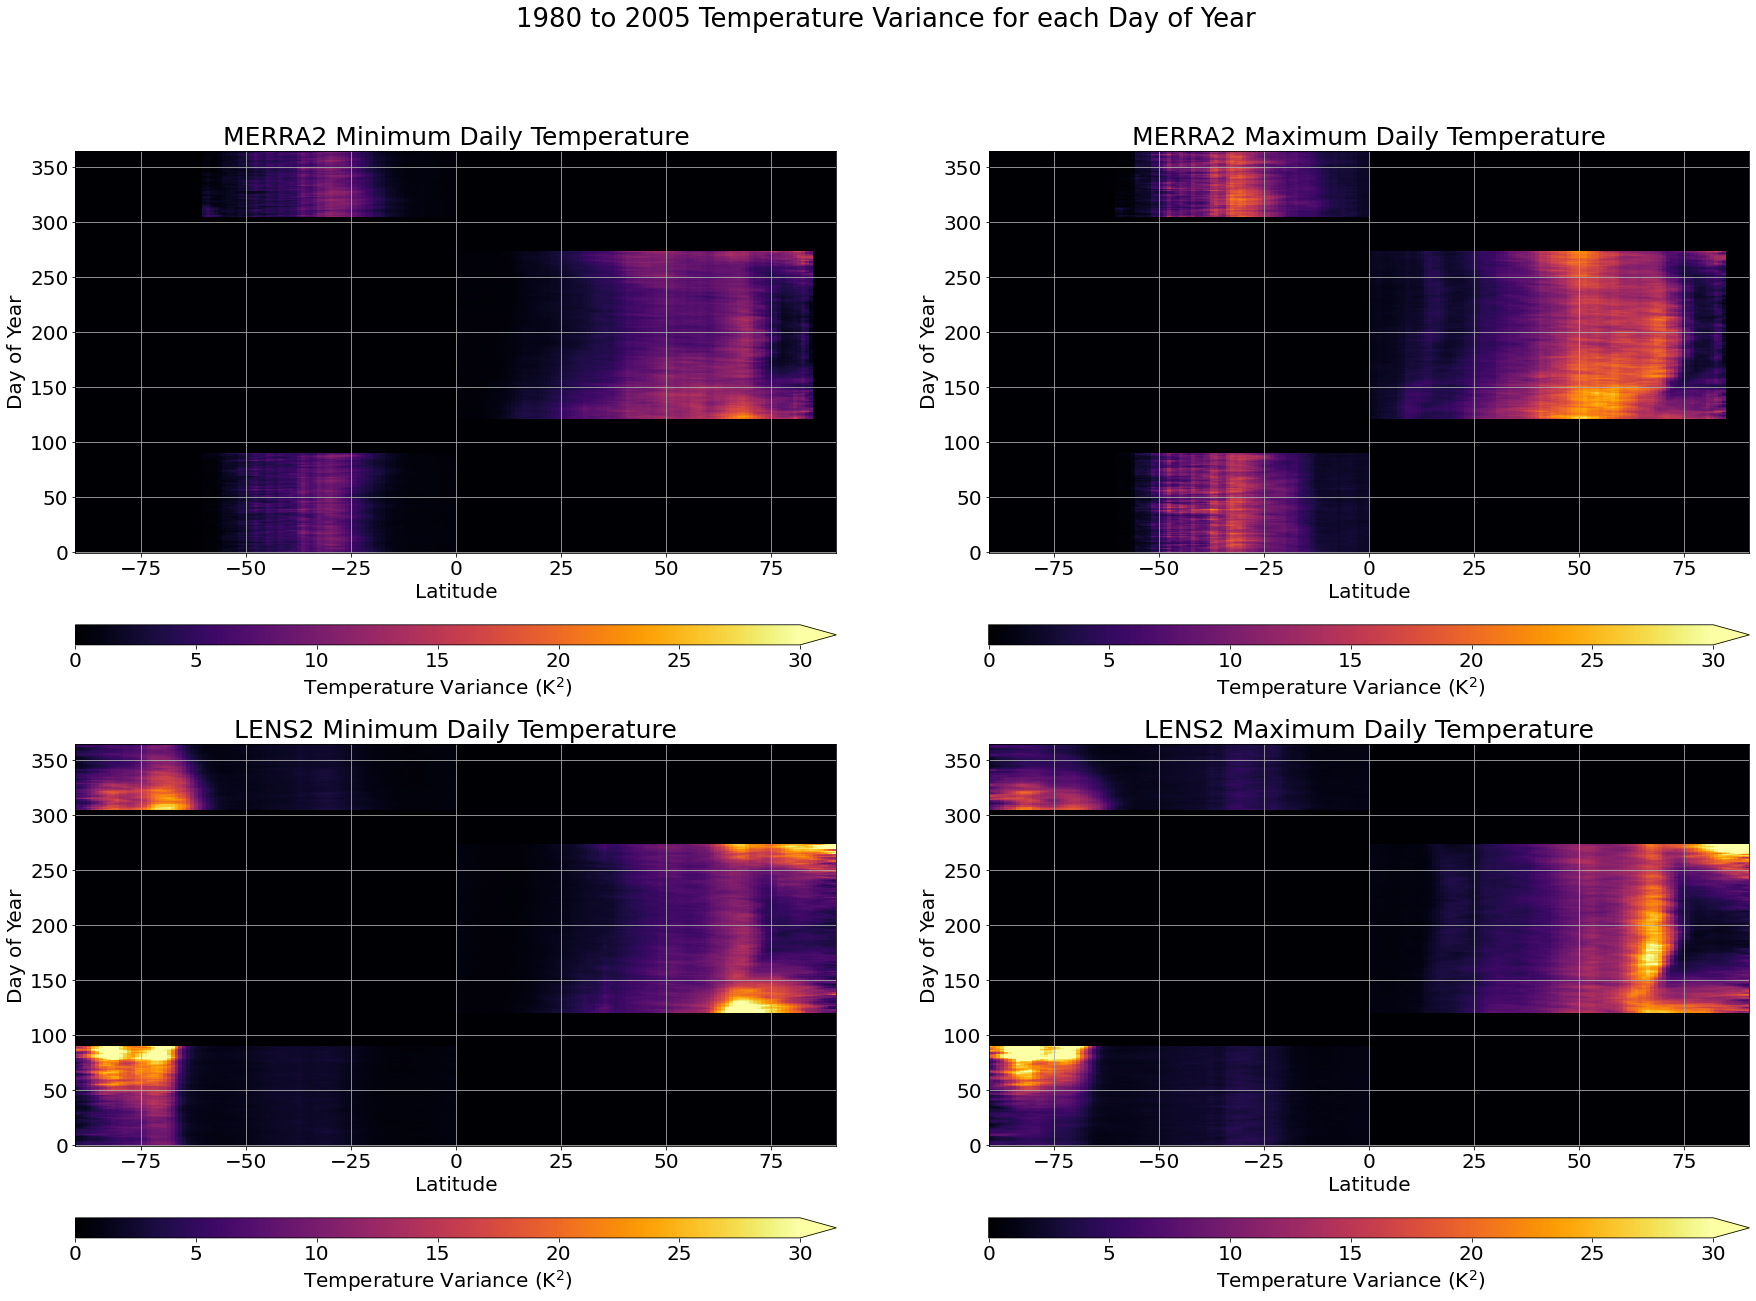

In [181]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 20), facecolor='w')
f.suptitle(f"1980 to 2005 Temperature Variance for each Day of Year", fontsize=26)
cmap="inferno"

rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

vmax = 30
vmin = 0

im1 = merra_min_var["variance"].mean(dim="lon").plot(ax=ax1, vmax=vmax, vmin=vmin, cmap=cmap, add_colorbar=False)
im2 = merra_max_var["variance"].mean(dim="lon").plot(ax=ax2, vmax=vmax, vmin=vmin, cmap=cmap, add_colorbar=False)
im3 = lens2_min_var["variance"].mean(dim="lon").plot(ax=ax3, vmax=vmax, vmin=vmin, cmap=cmap, add_colorbar=False)
im4 = lens2_max_var["variance"].mean(dim="lon").plot(ax=ax4, vmax=vmax, vmin=vmin, cmap=cmap, add_colorbar=False)

cs = 20
cax1 = make_axes_locatable(ax1).append_axes('bottom', size='5%', pad=1)
cb1 = f.colorbar(im1, cax=cax1, orientation="horizontal", pad=0.15, extend="max")
cb1.set_label(label='Temperature Variance (K$^{2}$)', size=cs)
cax2 = make_axes_locatable(ax2).append_axes('bottom', size='5%', pad=1)
cb2 = f.colorbar(im2, cax=cax2, orientation="horizontal", pad=0.15, extend="max")
cb2.set_label(label='Temperature Variance (K$^{2}$)', size=cs)
cax3 = make_axes_locatable(ax3).append_axes('bottom', size='5%', pad=1)
cb3 = f.colorbar(im3, cax=cax3, orientation="horizontal", pad=0.15, extend="max")
cb3.set_label(label='Temperature Variance (K$^{2}$)', size=cs)
cax4 = make_axes_locatable(ax4).append_axes('bottom', size='5%', pad=1)
cb4 = f.colorbar(im4, cax=cax4, orientation="horizontal", pad=0.15, extend="max")
cb4.set_label(label='Temperature Variance (K$^{2}$)', size=cs)


ts=25
ax1.set_title("MERRA2 Minimum Daily Temperature", fontsize=ts)
ax2.set_title("MERRA2 Maximum Daily Temperature", fontsize=ts)
ax3.set_title("LENS2 Minimum Daily Temperature", fontsize=ts)
ax4.set_title("LENS2 Maximum Daily Temperature", fontsize=ts)


ls = 20
ax1.set_xlabel("Latitude", fontsize=ls)
ax1.set_ylabel("Day of Year", fontsize=ls)
ax2.set_xlabel("Latitude", fontsize=ls)
ax2.set_ylabel("Day of Year", fontsize=ls)
ax3.set_xlabel("Latitude", fontsize=ls)
ax3.set_ylabel("Day of Year", fontsize=ls)
ax4.set_xlabel("Latitude", fontsize=ls)
ax4.set_ylabel("Day of Year", fontsize=ls)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

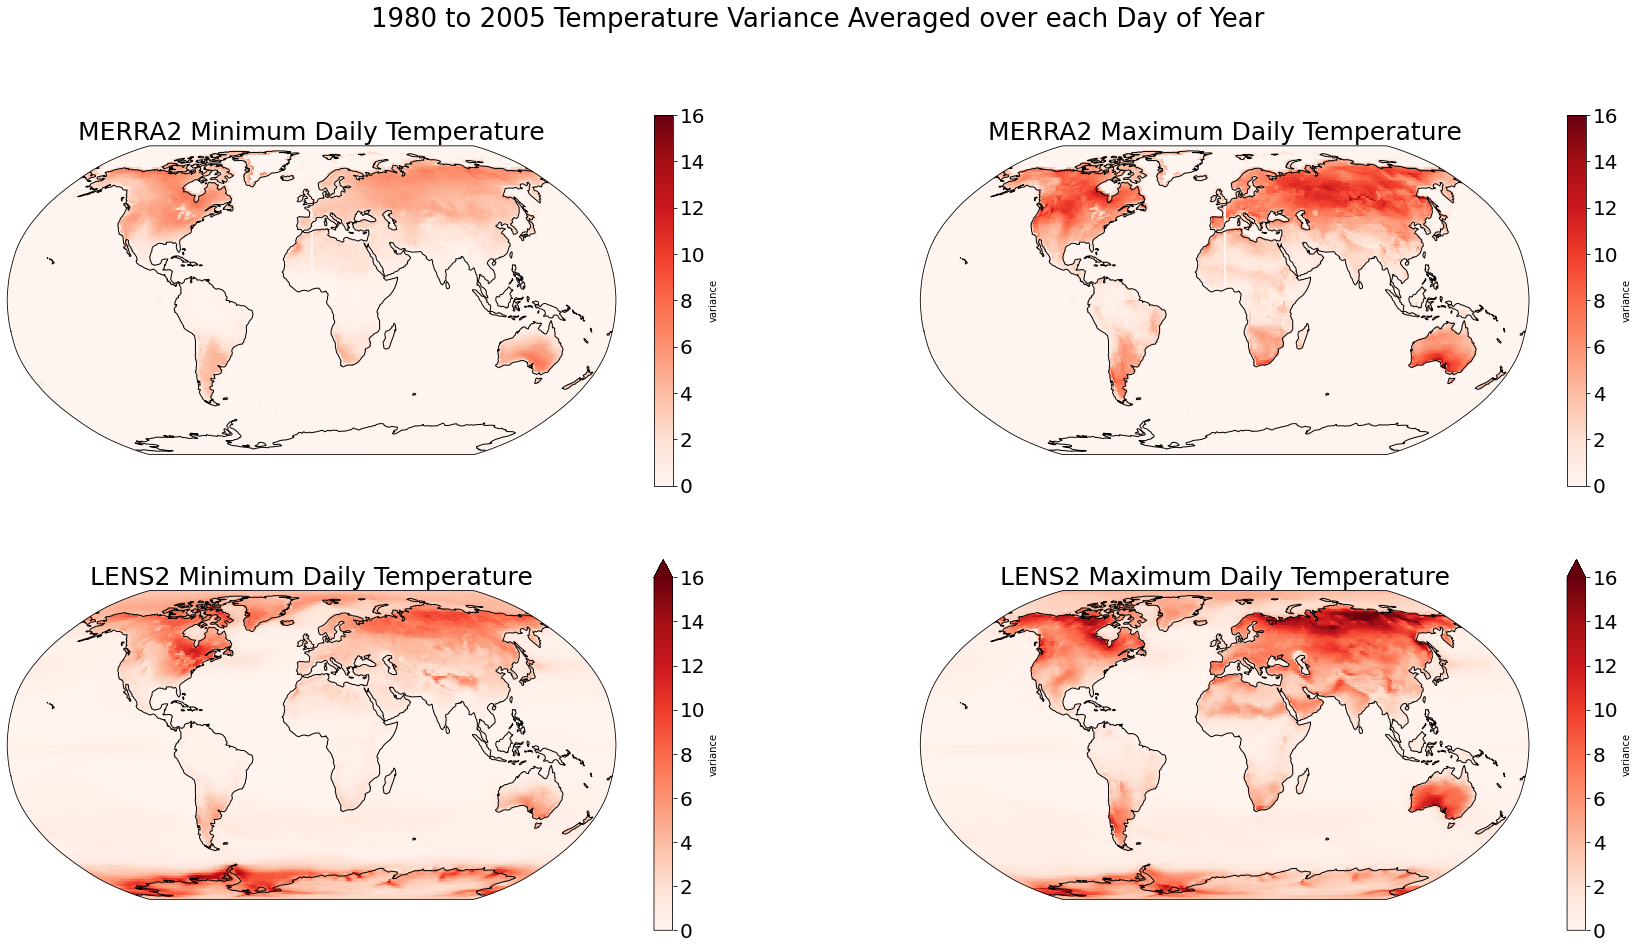

In [189]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 15), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"1980 to 2005 Temperature Variance Averaged over each Day of Year", fontsize=26)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

cmap="Reds"
vmax=16
vmin=0

merra_min_var["variance"].mean(dim="day").plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())
merra_max_var["variance"].mean(dim="day").plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())
lens2_min_var["variance"].mean(dim="day").plot(ax=ax3, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())
lens2_max_var["variance"].mean(dim="day").plot(ax=ax4, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())

ts=25
ax1.set_title("MERRA2 Minimum Daily Temperature", fontsize=ts)
ax2.set_title("MERRA2 Maximum Daily Temperature", fontsize=ts)
ax3.set_title("LENS2 Minimum Daily Temperature", fontsize=ts)
ax4.set_title("LENS2 Maximum Daily Temperature", fontsize=ts)

ax1.coastlines()
ax2.coastlines()
ax3.coastlines()
ax4.coastlines()

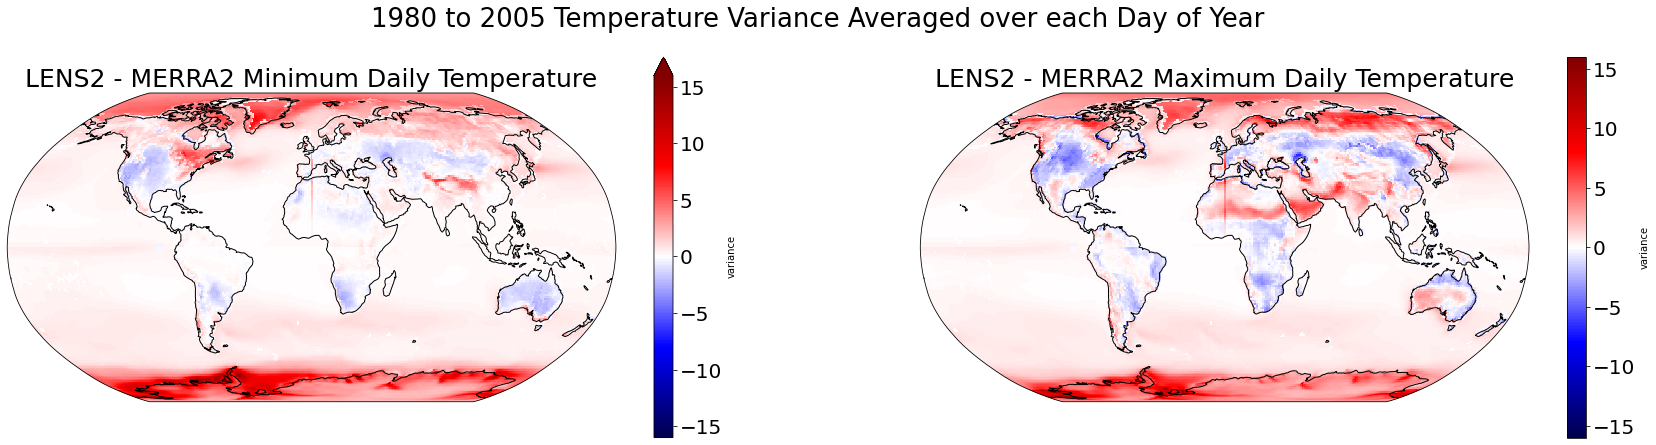

In [186]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 7), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"1980 to 2005 Temperature Variance Averaged over each Day of Year", fontsize=26)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

cmap="seismic"
vmax=16
vmin=-16

diff1 = lens2_min_var["variance"].mean(dim="day") - merra_min_var["variance"].mean(dim="day")
diff1.plot(ax=ax1, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())
diff2 = lens2_max_var["variance"].mean(dim="day") - merra_max_var["variance"].mean(dim="day")
diff2.plot(ax=ax2, cmap=cmap, vmax=vmax, vmin=vmin, transform=ccrs.PlateCarree())
ts=25
ax1.set_title("LENS2 - MERRA2 Minimum Daily Temperature", fontsize=ts)
ax2.set_title("LENS2 - MERRA2 Maximum Daily Temperature", fontsize=ts)

ax1.coastlines()
ax2.coastlines()